# MIT IQuHack - IonQ Challenge

In [1]:
import json
import pickle
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from typing import Dict, List
from IPython.display import clear_output

import qiskit
from qiskit import quantum_info
from qiskit.execute_function import execute
from qiskit import BasicAer
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, RealAmplitudes
from qiskit.quantum_info import SparsePauliOp
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# algorithm_globals.random_seed = 12345

## Part 1: Encoding and Decoding

In [2]:
def simulate(circuit: qiskit.QuantumCircuit) -> dict:
    """Simulate the circuit, give the state vector as the result."""
    
    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    result = job.result()
    state_vector = result.get_statevector()
    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i]) ** 2
        if population > 1e-9:
            histogram[i] = population
    
    return histogram

def histogram_to_category(histogram):
    assert abs(sum(histogram.values())-1)<1e-8
    positive=0
    for key in histogram.keys():
        digits = bin(int(key))[2:].zfill(20)
        if digits[-1]=='0':
            positive+=histogram[key]
        
    return positive

def count_gates(circuit: qiskit.QuantumCircuit) -> Dict[int, int]:
    """Returns the number of gate operations with each number of qubits."""
    return Counter([len(gate[1]) for gate in circuit.data])


def image_mse(image1,image2):
    return mean_squared_error(image1, image2)

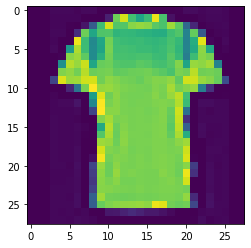

In [3]:
#load the actual hackthon data (fashion-mnist)

images=np.load('data/images.npy')
labels=np.load('data/labels.npy')

plt.imshow(images[1])

In [4]:
sample_img = np.matrix(images[1])
def downsizing(sample_img):
    test_img = np.zeros((4,4))
    break_pt = [7,14,21,28]
    for i in range(4):
        for j in range(4):
            test_img[i,j] = round(np.mean(sample_img[7*i:break_pt[i],7*j:break_pt[j]]),4)
    return test_img

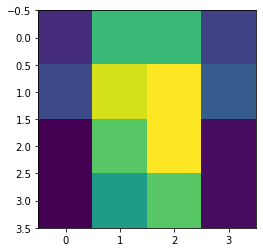

In [5]:
test_img = downsizing(sample_img)
plt.imshow(test_img)

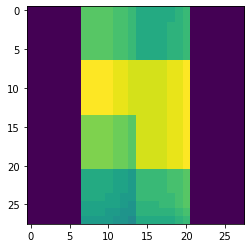

In [6]:
def reconstruction(test_img):
    img = np.zeros((28,28))
    min_img = 1e-4
    for i in range(7):
        for j in range(7):
            img[6-i,6-j] = max(round(test_img[0,0] - j**3*1e-5 - 3*i*1e-6 - 2*min_img,2),0)

    for i in range(7):
        for j in range(7):
            img[6-i,21+j] = max(round(test_img[0,3]-2*min_img -j**3*1e-5 -i*3*1e-6,2),0)

    for k in range(2):
        for i in range(7):
            for j in range(7):
                img[6-i,7*(k+1) + j]= max(round(test_img[0,k+1]-2*np.sign(k-0.5)*min_img + np.sign(k-0.5)*j**3*1e-6 - 3*i*1e-6,4),0)

    for i in range(7):
        for j in range(7):
            img[13-i,6-j] = max(round(test_img[1,0] - j**3*1e-5 - 2*min_img,2),0)
    for i in range(7):
        for j in range(7):
            img[13-i,21+j] = max(round(test_img[1,3]-2*min_img -j**3*1e-5 ,2),0)
    for k in range(2):
        for i in range(7):
            for j in range(7):
                img[13-i,7*k+7+j]= round(test_img[1,k+1]-2*np.sign(k-0.5)*min_img+ np.sign(k-0.5)*j**3*1e-6 ,4)
    
    for i in range(7):
        for j in range(7):
            img[20-i,6-j] = max(round(test_img[2,0] - j**3*1e-5 - 2*min_img,2),0)
    for i in range(7):
        for j in range(7):
            img[20-i,21+j] = max(round(test_img[2,3]-2*min_img -j**3*1e-5 ,2),0)
    for k in range(2):
        for i in range(7):
            for j in range(7):
                img[20-i,7*k+7+j]= round(test_img[2,k+1]-2*np.sign(k-0.5)*min_img+ np.sign(k-0.5)*j**3*1e-6 ,4)
    
    for i in range(7):
        for j in range(7):
            img[21+i,6-j] = max(round(test_img[3,0] - j**3*1e-5 -i**3*1e-6- 2*min_img,2),0)
    for i in range(7):
        for j in range(7):
            img[21+i,21+j] = max(round(test_img[3,3]-2*min_img-i**3*1e-6 -j**3*1e-5 ,2),0)
    for k in range(2):
        for i in range(7):
            for j in range(7):
                img[21+i,7*k+7+j]= round(test_img[3,k+1]-i**3*1e-6-2*np.sign(k-0.5)*min_img+ np.sign(k-0.5)*j**3*1e-6 ,4)
                
    return img
plt.imshow(reconstruction(test_img))

In [7]:
np.linalg.norm(reconstruction(test_img)-sample_img)

0.029583825135294426

In [8]:
def decode(histogram): 
    n=16
    options = {}
    hist_keys = list(histogram.keys())
    for i in range(n):
        options[i]=0
    for i in range(len(histogram)):
        for j in range(i,len(histogram)):
            x = hist_keys[i]^hist_keys[j]
            if x and (not(x & (x-1))):
                val1 = bin(hist_keys[i])[2:].zfill(n)
                val2 = bin(hist_keys[j])[2:].zfill(n)
                for k in range(n):
                    if val1[k]!=val2[k]:
                        if options[n-1-k] ==0:                            
                            options[n-1-k] = 2*np.arctan(np.sqrt(histogram[hist_keys[j]]/histogram[hist_keys[i]]))
            else:
                continue
    image = []
    for i in range(n):
        image.append(round(options[i]/10,4))
    return reconstruction(np.asarray(image).reshape((4,4)))

In [9]:
def encode(image):
    img_arr = np.asarray(downsizing(image)).reshape(-1)
    desired_state = img_arr
    q = qiskit.QuantumRegister(len(desired_state))
    circuit = qiskit.QuantumCircuit(q)
    i=0
    for ele in desired_state:
        if ele>1e-8:
            circuit.rx(10*ele,i)
        i+=1
    circuit.decompose().draw()
    return circuit

In [10]:
J = sample_img
encode(J).draw()


┌───────────┐
 q0_0: ┤ Rx(0.004) ├
       ├───────────┤
 q0_1: ┤ Rx(0.021) ├
       ├───────────┤
 q0_2: ┤ Rx(0.021) ├
       ├───────────┤
 q0_3: ┤ Rx(0.006) ├
       ├───────────┤
 q0_4: ┤ Rx(0.007) ├
       ├───────────┤
 q0_5: ┤ Rx(0.029) ├
       ├───────────┤
 q0_6: ┤ Rx(0.031) ├
       ├───────────┤
 q0_7: ┤ Rx(0.009) ├
       └───────────┘
 q0_8: ─────────────
       ┌───────────┐
 q0_9: ┤ Rx(0.023) ├
       ├───────────┤
q0_10: ┤ Rx(0.031) ├
       ├───────────┤
q0_11: ┤ Rx(0.001) ├
       └───────────┘
q0_12: ─────────────
       ┌───────────┐
q0_13: ┤ Rx(0.017) ├
       ├───────────┤
q0_14: ┤ Rx(0.023) ├
       ├───────────┤
q0_15: ┤ Rx(0.001) ├
       └───────────┘

In [11]:
circuit=encode(J)

#simulate circuit
histogram=simulate(circuit)

In [ ]:
n = len(images)
mse=0
gatecount=0

for image in images:
    #encode image into circuit
    #J = downsizing(image)
    circuit=encode(image)

    #simulate circuit
    histogram=simulate(circuit)

    #count the number of 2-qubit gates
    gatecount+=count_gates(circuit)[2]
    #print(gatecount)

    #reconstruct the image
    image_re=decode(histogram)
    #image_rec = reconstruction(downsizing(image))
    #calculate mse
    mse+=image_mse(np.asarray(image),image_re)
#fidelity of reconstruction
f=1-mse/n
gatecount=gatecount/n

#score for part1
print(f*(0.999**gatecount))

## Part 2: Classification

### Train Test Data

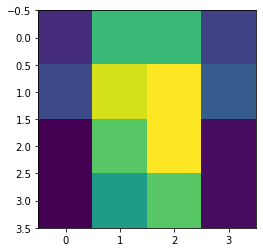

In [12]:
image = []
for i in range(len(images)):
    j = np.matrix(images[i])
    image.append(downsizing(j))

images = image
plt.imshow(images[1])

[0.0009 0.0021 0.0022 0.0009 0.001  0.0019 0.002  0.001  0.     0.0023
 0.0025 0.     0.     0.0024 0.0025 0.    ] [0.0003 0.0027 0.0026 0.0004 0.0006 0.0028 0.0027 0.0009 0.     0.0029
 0.0032 0.     0.     0.0028 0.0032 0.    ]


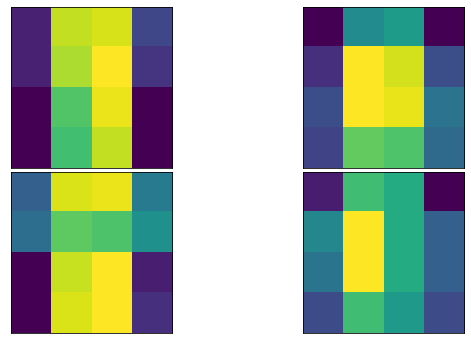

In [13]:
image = []
for i in images:
    image.append(i.flatten())

images = image

print(images[0], images[2])
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3
)

#Let’s see some examples in our dataset

fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i // 2, i % 2].imshow(
        train_images[i].reshape(4,4), 
        aspect="equal",
    )
plt.subplots_adjust(wspace=0.1, hspace=0.025)

In [14]:
images[0]

array([0.0009, 0.0021, 0.0022, 0.0009, 0.001 , 0.0019, 0.002 , 0.001 ,
       0.    , 0.0023, 0.0025, 0.    , 0.    , 0.0024, 0.0025, 0.    ])

### Normal QNN

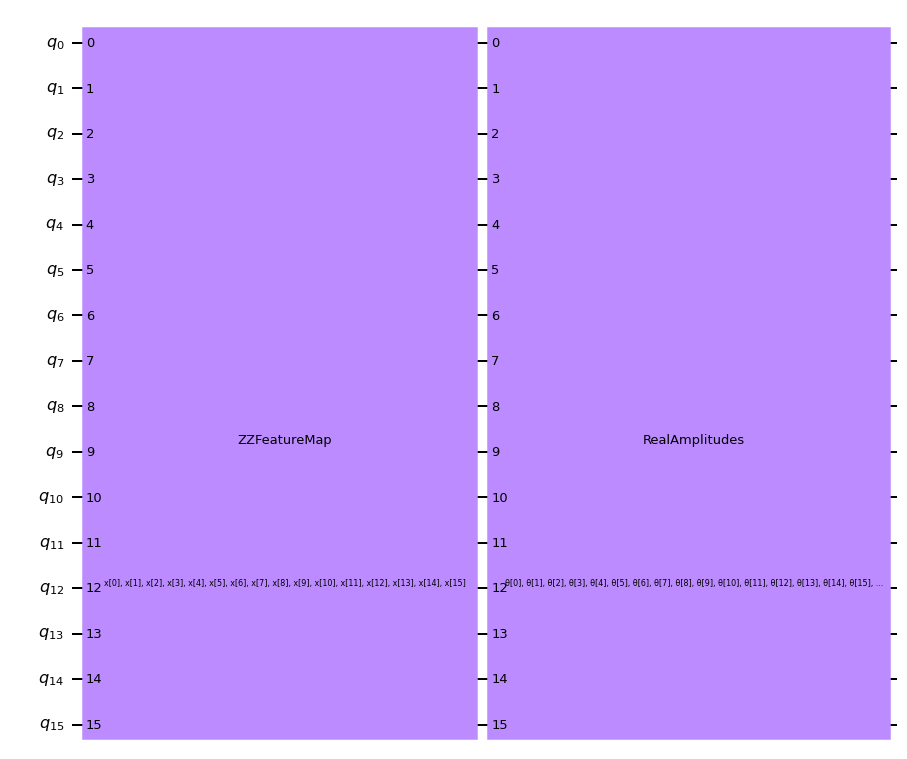

In [15]:
qc = QuantumCircuit(16)
feature_map = ZZFeatureMap(16)
ansatz = RealAmplitudes(16)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)
qc.draw(output="mpl")


In [17]:
estimator_qnn = EstimatorQNN(
    circuit=qc, input_params=feature_map.parameters, weight_params=ansatz.parameters
)

In [18]:
estimator_qnn.forward(train_images, algorithm_globals.random.random(estimator_qnn.num_weights))

array([[0.03199286],
       [0.03061668],
       [0.03242512],
       ...,
       [0.02953379],
       [0.0294058 ],
       [0.03137777]])

In [19]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [20]:
estimator_classifier = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=60), callback=callback_graph
)

In [21]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier.fit(train_images, train_labels)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
estimator_classifier.score(X, y)

NameError: name 'X' is not defined

In [ ]:
estimator_classifier.weights

In [ ]:
circuits = [qc.bind_parameters({theta: theta_val})
            for theta_val in estimator_classifier.weights]

### Quantum Convolutional Neural Network Method

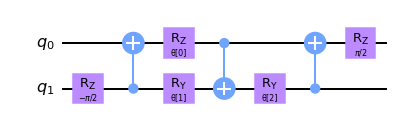

In [127]:
# We now define a two qubit unitary as defined in [3]
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl")

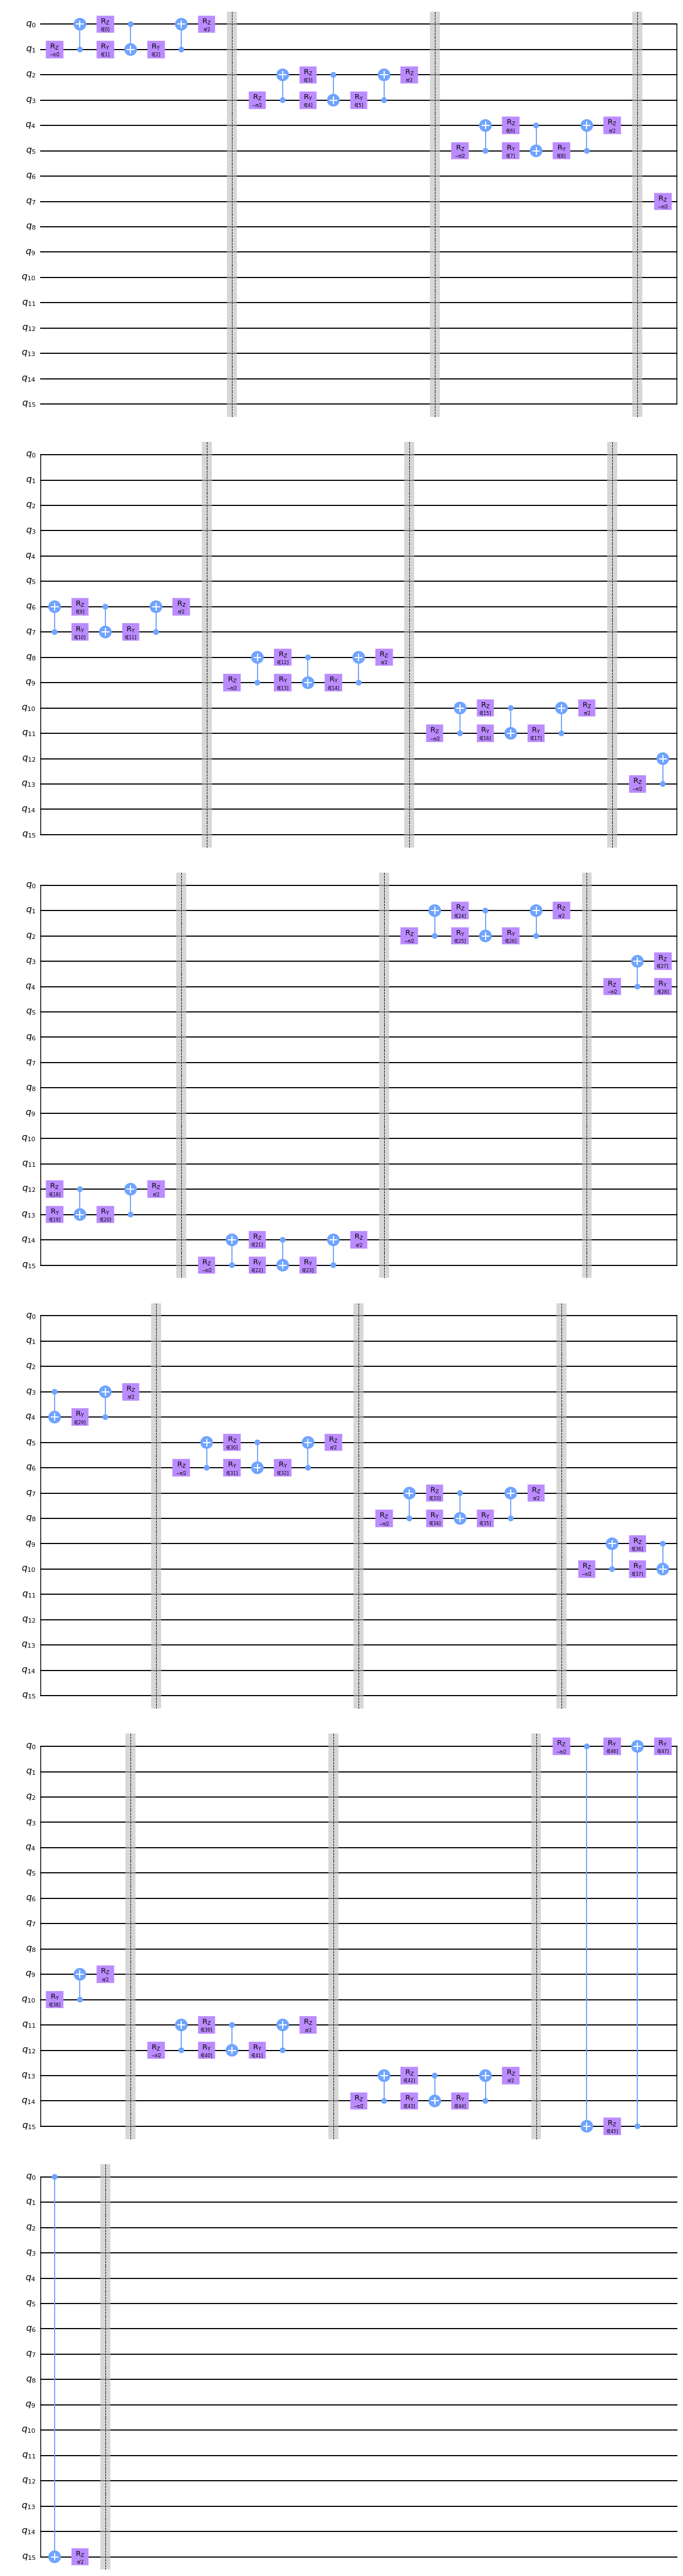

In [128]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(16, "θ")
circuit.decompose().draw("mpl")

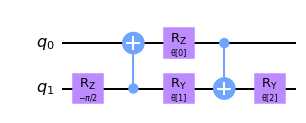

In [129]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl")

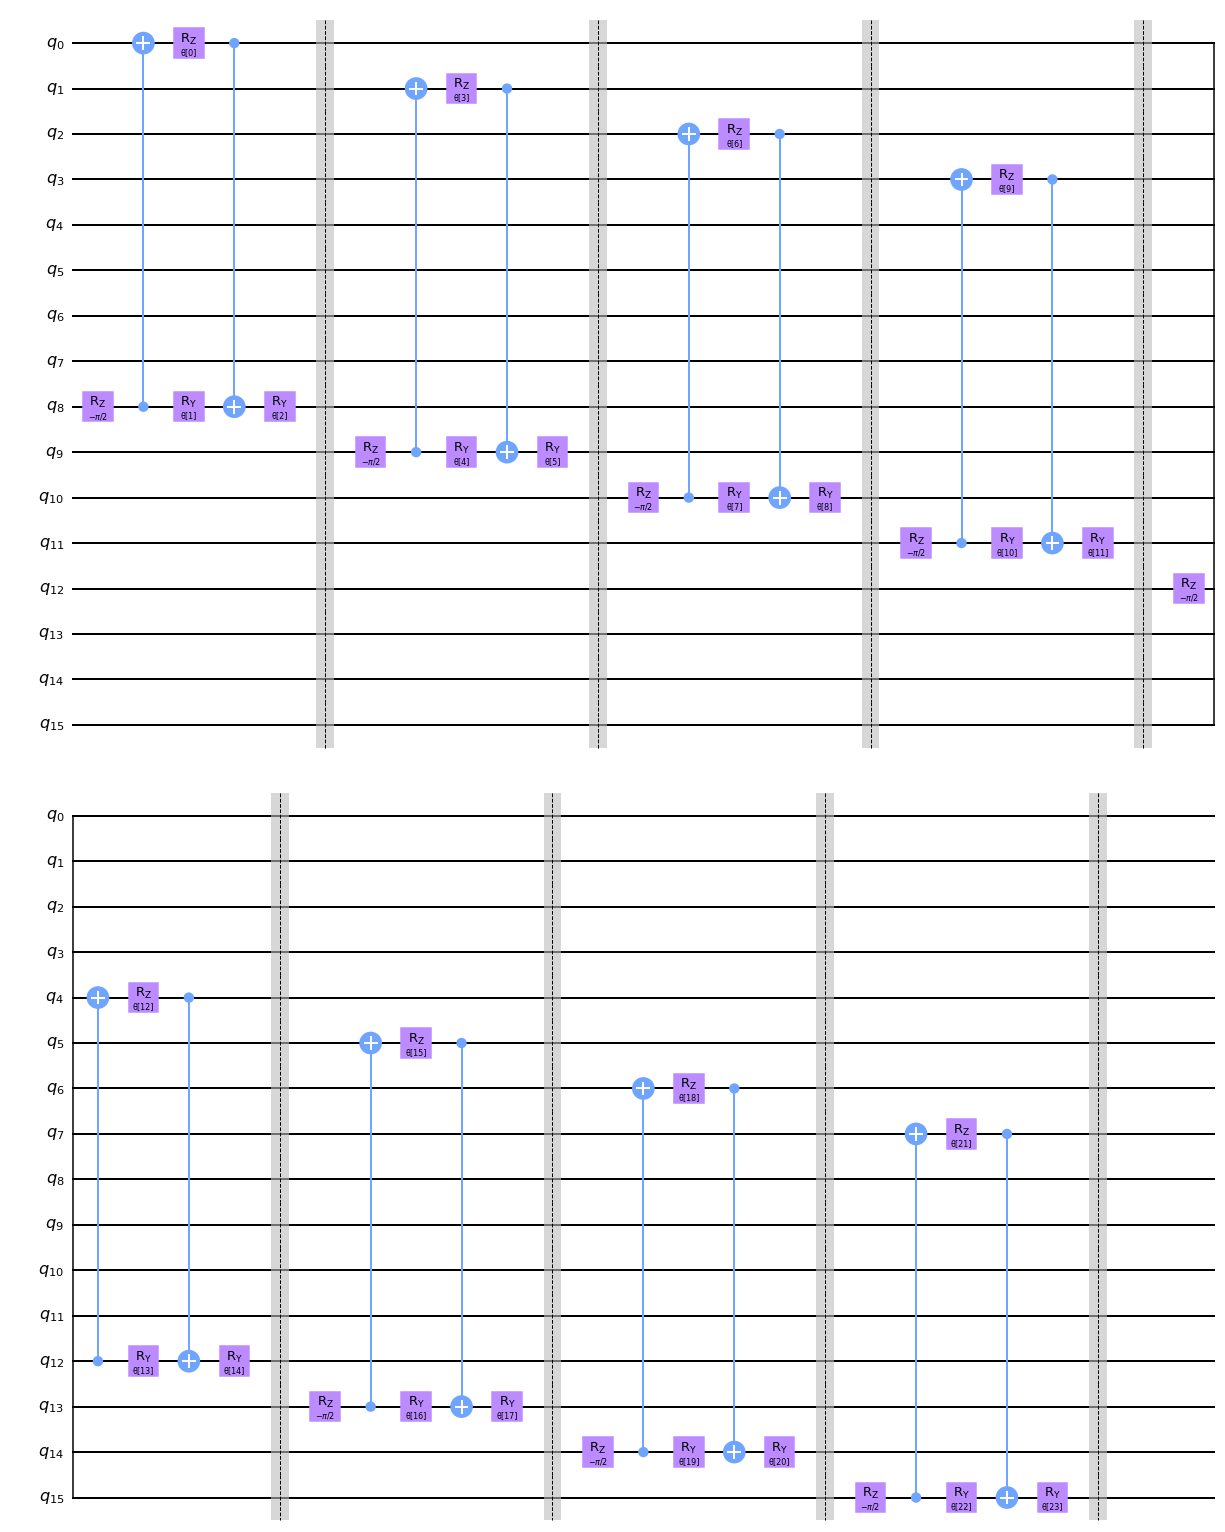

In [130]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [i for i in range(0,8)]
sinks = [i for i in range(8,16)]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl")


In [145]:
feature= ZFeatureMap(16)
ansatz = QuantumCircuit(16, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(16, "с1"), list(range(16)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([i for i in range(0,8)], [i for i in range(8,16)], "p1"), list(range(16)), inplace=True)

# First Convolutional Layer
ansatz.compose(conv_layer(8, "с2"), list(range(8,16)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([i for i in range(0,4)], [i for i in range(4,8)], "p2"), list(range(8,16)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c3"), list(range(12, 16)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([i for i in range(0,2)], [i for i in range(2,4)], "p3"), list(range(12,16)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c4"), list(range(14, 16)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p4"), list(range(14,16)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(16)
circuit.compose(feature_map, range(16), inplace=True)
circuit.compose(ansatz, range(16), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 15, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

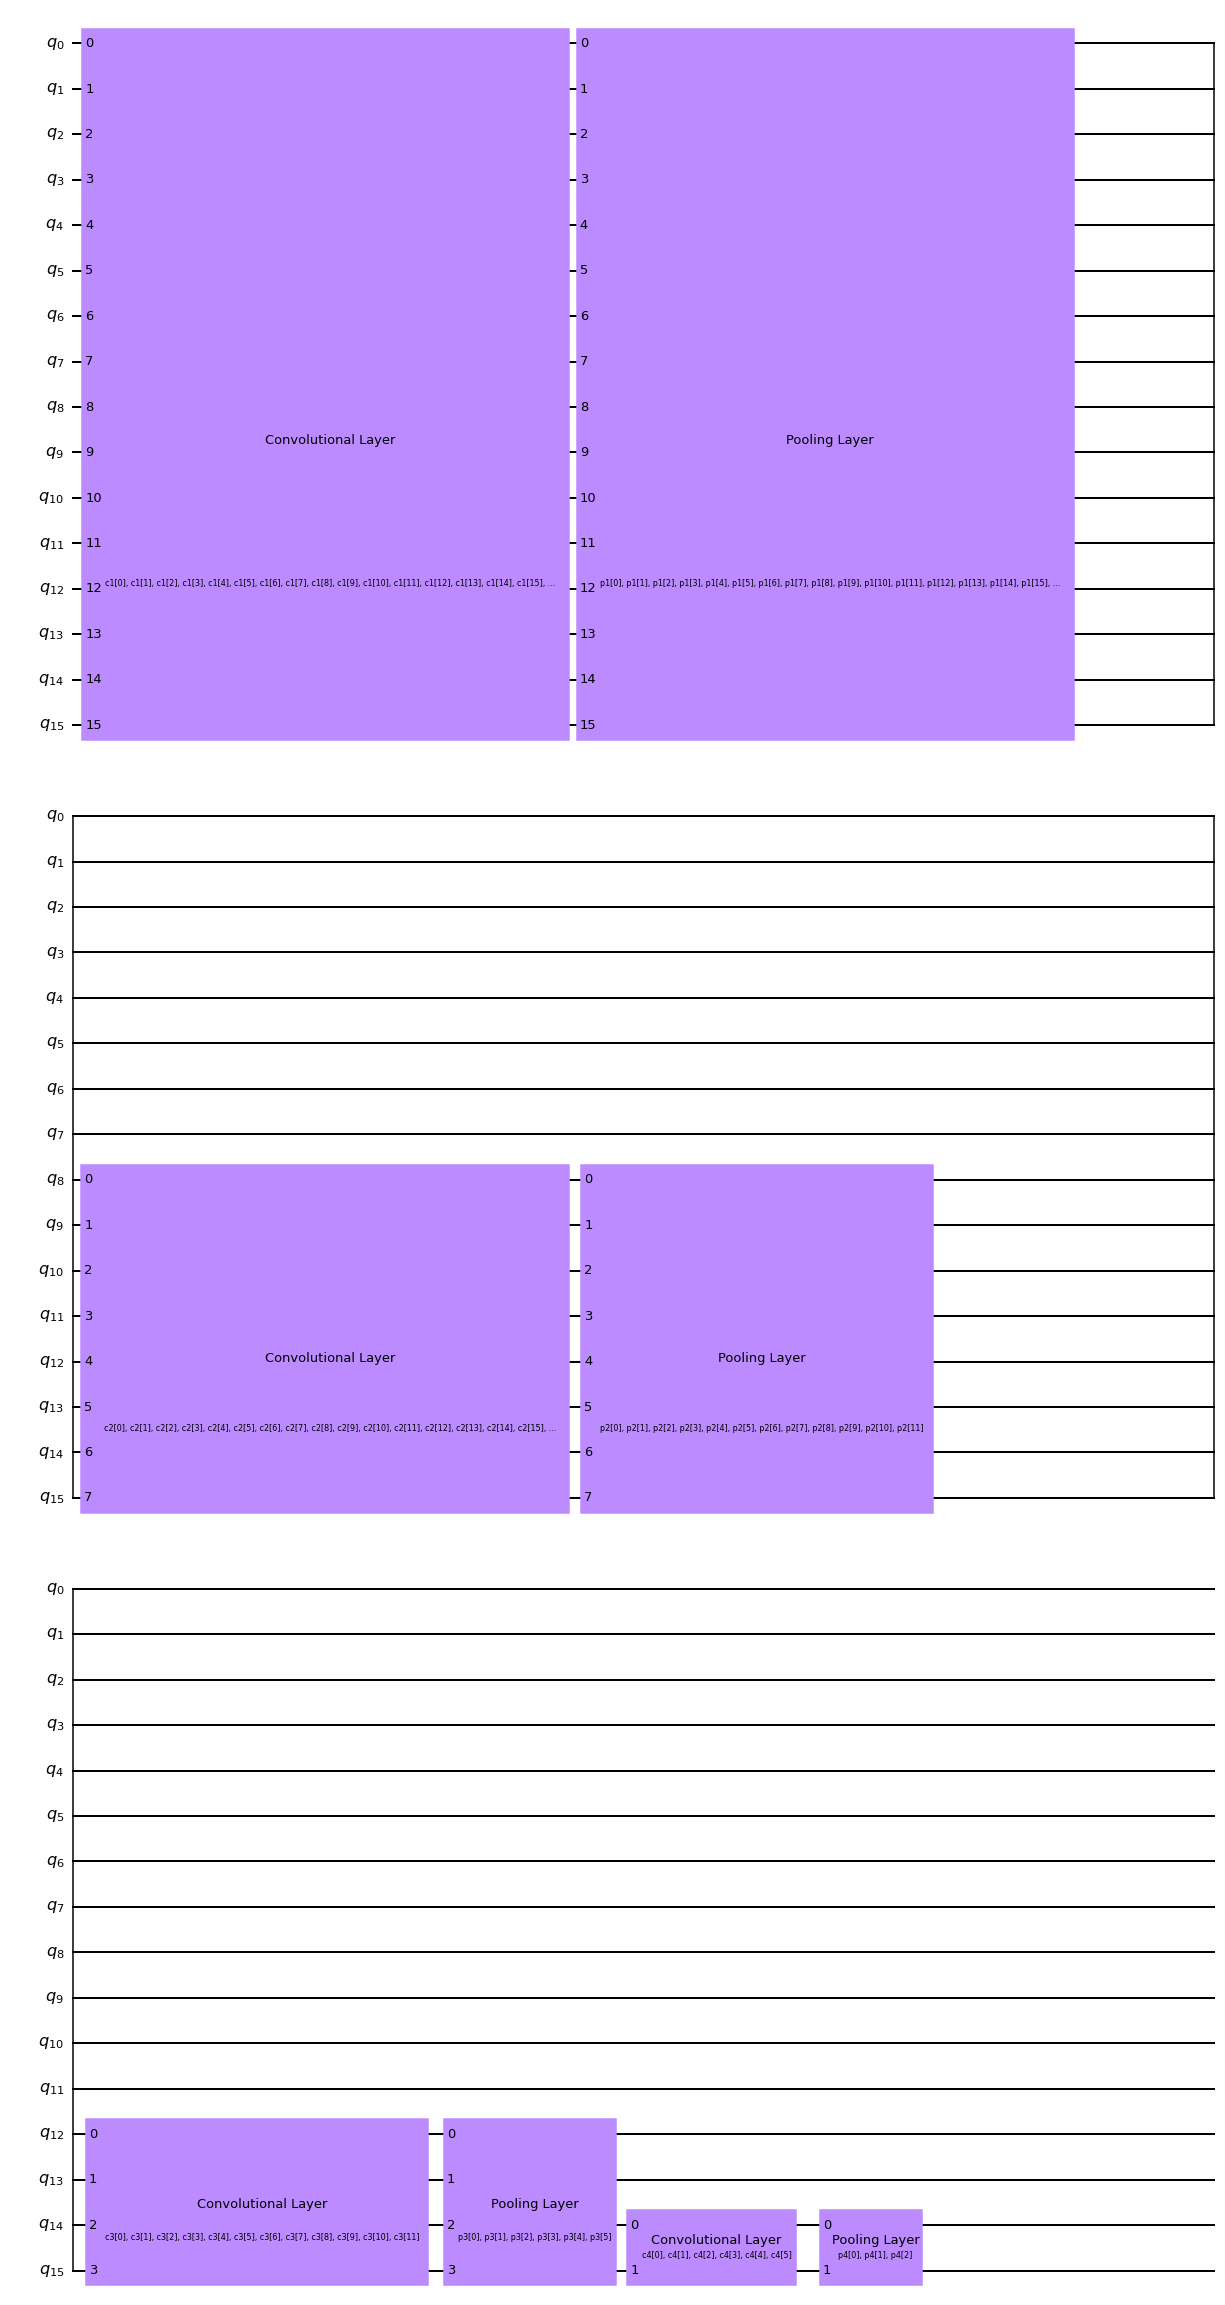

In [146]:
circuit.draw("mpl")

In [148]:
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=50),  # Set max iterations here
    callback=callback_graph,
    #initial_point=initial_point,
)

In [ ]:
x = np.asarray(train_images)
y = np.asarray(train_labels)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

In [ ]:
y_predict = classifier.predict(test_images)
x = np.asarray(test_images)
y = np.asarray(test_labels)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

# Let's see some examples in our dataset
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(test_images[i].reshape(4, 4), aspect="equal")
    if y_predict[i] == -1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Horizontal Line")
    if y_predict[i] == +1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Vertical Line")
plt.subplots_adjust(wspace=0.1, hspace=0.5)